# Fine tuning using GPT2 XL

### Base Model and Quantization

In [1]:
# GPU 0: NVIDIA GeForce RTX 4090
# GPU 1: NVIDIA GeForce RTX 4090
# GPU 2: NVIDIA GeForce RTX 4090
# GPU 3: NVIDIA GeForce RTX 3090 Ti
# GPU 4: NVIDIA GeForce RTX 3090 Ti
# GPU 5: NVIDIA GeForce RTX 3090
# GPU 6: NVIDIA GeForce RTX 3090
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"  # ""makes all visible, "0" GPU 0 visible

### Supress warnings

In [2]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

### Inspect the base model

In [3]:
import os
import torch

from transformers import AutoModelForSequenceClassification, BitsAndBytesConfig

model_name = "gpt2-xl"
checkpoint = "openai-community/"+model_name

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

access_token = os.getenv("HF_TOKEN")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, quantization_config=bnb_config, device_map="auto", num_labels=2, token=access_token)

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2-xl and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                             Param #
GPT2ForSequenceClassification                      --
├─GPT2Model: 1-1                                   --
│    └─Embedding: 2-1                              80,411,200
│    └─Embedding: 2-2                              1,638,400
│    └─Dropout: 2-3                                --
│    └─ModuleList: 2-4                             --
│    │    └─GPT2Block: 3-1                         15,380,800
│    │    └─GPT2Block: 3-2                         15,380,800
│    │    └─GPT2Block: 3-3                         15,380,800
│    │    └─GPT2Block: 3-4                         15,380,800
│    │    └─GPT2Block: 3-5                         15,380,800
│    │    └─GPT2Block: 3-6                         15,380,800
│    │    └─GPT2Block: 3-7                         15,380,800
│    │    └─GPT2Block: 3-8                         15,380,800
│    │    └─GPT2Block: 3-9                         15,380,800
│    │    └─GPT2Block: 3-10                 

In [5]:
model

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=1600, out_features=4800, bias=True)
          (c_proj): Linear4bit(in_features=1600, out_features=1600, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=1600, out_features=6400, bias=True)
          (c_proj): Linear4bit(in_features=6400, out_features=1600, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=

### Load the news dataset from pickle file
If any of the check_files don't exist then load the pickle file

In [4]:
import pickle

base_path = './data/'
os.makedirs(base_path, exist_ok=True)

file_name = 'news_small_dataset.pkl'
file_path = base_path+file_name

def pickle_dataset(dataset, file_path):
    with open(file_path, 'wb') as file:
        pickle.dump(dataset, file)
        print(f"Dataset has been pickled to: {file_path}")

def load_pickle_dataset(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
        print(f"Dataset has been loaded from: {file_path}")
    return dataset

def check_files_exists(file_names):
    for name in file_names:
        file_path = os.path.join(base_path, name)
        if os.path.exists(file_path):
            return True
    return False

# if these files exist we do not want to load the news_dataset.pkl to tokenize and make these files
check_files = [model_name+'-small_tokenized_train_ds.pkl', model_name+'-small_tokenized_eval_ds.pkl', model_name+'-small_tokenized_test_ds.pkl']

if check_files_exists(check_files):
    print("At least one of the specified files already exists. Not loading new dataset.")
else:
    news_split_ds = load_pickle_dataset(file_path)
    print(news_split_ds)
    total_rows = (news_split_ds['train'].num_rows +
              news_split_ds['eval'].num_rows +
              news_split_ds['test'].num_rows)
    print("Total number of rows:", total_rows)
    print("Dataset loaded successfully.")

At least one of the specified files already exists. Not loading new dataset.


### Tokenization of data

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(checkpoint, token=access_token)

tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)

def tokenize_fn(news):
    return tokenizer(news['article'], padding=True, truncation=True, max_length=512, return_tensors="pt")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### Tokenize train, evaluation, and test datasets
If any of the check files exist then don't run tokenization and save some time.
Else load the pickle files that already exist.

In [6]:
if not check_files_exists(check_files):
    tokenized_train_ds = news_split_ds['train'].map(tokenize_fn, batched=True)
    tokenized_eval_ds = news_split_ds['eval'].map(tokenize_fn, batched=True)
    tokenized_test_ds = news_split_ds['test'].map(tokenize_fn, batched=True)

    print(tokenized_train_ds.features)
    print(tokenized_eval_ds.features)
    print(tokenized_test_ds.features)
    
    pickle_dataset(tokenized_train_ds, base_path+model_name+'-small_tokenized_train_ds.pkl')
    pickle_dataset(tokenized_eval_ds, base_path+model_name+'-small_tokenized_eval_ds.pkl')
    pickle_dataset(tokenized_test_ds, base_path+model_name+'-small_tokenized_test_ds.pkl')
else:
    print("Files already exist, so load datasets")
    tokenized_train_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_train_ds.pkl')
    tokenized_eval_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_eval_ds.pkl')
    tokenized_test_ds = load_pickle_dataset(base_path+model_name+'-small_tokenized_test_ds.pkl')

Files already exist, so load datasets
Dataset has been loaded from: ./data/gpt2-xl-small_tokenized_train_ds.pkl
Dataset has been loaded from: ./data/gpt2-xl-small_tokenized_eval_ds.pkl
Dataset has been loaded from: ./data/gpt2-xl-small_tokenized_test_ds.pkl


### Look at the tokenized data
Notice what the actual data looks like, and then the tokenized data which is a bunch of numbers, and then the attention mask at the end.

In [9]:
count_train_records = len(tokenized_train_ds)
count_eval_records = len(tokenized_eval_ds)
count_test_records = len(tokenized_test_ds)
print(f"Number of records in training dataset: {count_train_records}")
print(f"Number of records in evaluation dataset: {count_eval_records}")
print(f"Number of records in test dataset: {count_test_records}")
count_total_records = count_train_records + count_eval_records + count_test_records
print(f"Total number of records: {count_total_records}")

Number of records in training dataset: 33611
Number of records in evaluation dataset: 7203
Number of records in test dataset: 7203
Total number of records: 48017


In [10]:
first_record = tokenized_train_ds[0]
print(first_record)

{'article': "In a year where homicides, rapes and robberies increased slightly, New York City still saw serious crime drop 1.7 percent in 2015, continuing an overall decline that began in the 1990s, NYPD Commissioner William Bratton said Monday.\nAt a news conference with Mayor Bill de Blasio, Bratton touted last year’s crime statistics, which he said, when combined with an even larger decline in 2014, put to rest the fear that substantial decreases couldn’t continue under the new administration at City Hall.\n“While we have had some fluctuation, some increases in certain categories, the overall trend in all our crime categories continues to go down,” Bratton told reporters. “It was a very good year for us, 2015.\nHomicides increased by 4.5 percent in 2015, rising to 350 from 333 in the prior year, which was the lowest since 1994, said Deputy Commissioner Dermot Shea. Rapes increased 6 percent and robberies rose 2 percent, said Shea, who is in charge of data collection and operations f

### Turn on accelerate

In [7]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

### LoRA - Low-Rank Adaptation

In [12]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, TaskType

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=[
        "c_attn",
        "c_proj",
        "c_fc",
        "c_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,
    task_type=TaskType.SEQ_CLS,
)

model = get_peft_model(model, config)
model = accelerator.prepare_model(model)

### Inspect the model

In [13]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [14]:
print_trainable_parameters(model)
model

trainable params: 9833600 || all params: 830168000 || trainable%: 1.1845313237802468


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GPT2ForSequenceClassification(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 1600)
        (wpe): Embedding(1024, 1600)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-47): 48 x GPT2Block(
            (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1600, out_features=4800, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1600, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4800, bias=False)
                )
                (lora_embedding_A): Paramet

### Look at hardware

In [15]:
print(f"Available GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 3090 Ti


In [16]:
!nvidia-smi

Thu May 23 03:37:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
| 31%   37C    P8             36W /  420W |     612MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
if torch.cuda.device_count() > 1:
    model.is_parallelizable = True
    model.model_parallel = True

In [9]:
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    return {'accuracy': acc, 'f1': f1}

In [10]:
project_name = "praxis-"+model_name+"-small-finetune"
output_dir_path = "./" + project_name
output_dir_path

'./praxis-gpt2-xl-small-finetune'

In [20]:
import torch
torch.cuda.empty_cache()

### Training

In [21]:
import transformers
from pathlib import Path

transformers.set_seed(777)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_ds,
    eval_dataset=tokenized_eval_ds,
    args=transformers.TrainingArguments(
        output_dir=output_dir_path,
        num_train_epochs=10,
        logging_steps=10,
        logging_dir=output_dir_path+"/logs",
        evaluation_strategy='epoch',
        save_strategy='epoch',
        bf16=True,
        optim="paged_adamw_8bit",
        do_eval=True,
    ),
    compute_metrics=compute_metrics,
    data_collator = transformers.DataCollatorWithPadding(tokenizer=tokenizer),
)

model.config.use_cache = False
trainer.train(resume_from_checkpoint=False)  # Turn to True if power goes out...

2024-05-23 03:37:27.681059: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 03:37:28.500240: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
wandb: Currently logged in as: nispoe. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.146600,0.201667,0.931556,0.925498
2,0.222800,0.170906,0.957657,0.955389
3,0.210800,0.159432,0.960572,0.958512
4,0.014500,0.193122,0.961960,0.959600
5,0.000100,0.283855,0.958073,0.955102
6,0.000000,0.467204,0.949743,0.945773
7,0.000000,0.271371,0.967375,0.965559
8,0.000000,0.327796,0.963904,0.961675
9,0.000000,0.354279,0.962654,0.960220
10,0.000000,0.394751,0.962238,0.959702


TrainOutput(global_step=42020, training_loss=0.06657408978054118, metrics={'train_runtime': 87096.7497, 'train_samples_per_second': 3.859, 'train_steps_per_second': 0.482, 'total_flos': 1.533718291120128e+18, 'train_loss': 0.06657408978054118, 'epoch': 10.0})

### Determine best checkpoint

In [22]:
!ls -ltr {output_dir_path}

total 44
drwxr-xr-x 2 nispoe nispoe 4096 May 23 03:37 logs
drwxrwxr-x 2 nispoe nispoe 4096 May 23 06:02 checkpoint-4202
drwxrwxr-x 2 nispoe nispoe 4096 May 23 08:27 checkpoint-8404
drwxrwxr-x 2 nispoe nispoe 4096 May 23 10:52 checkpoint-12606
drwxrwxr-x 2 nispoe nispoe 4096 May 23 13:17 checkpoint-16808
drwxrwxr-x 2 nispoe nispoe 4096 May 23 15:43 checkpoint-21010
drwxrwxr-x 2 nispoe nispoe 4096 May 23 18:08 checkpoint-25212
drwxrwxr-x 2 nispoe nispoe 4096 May 23 20:33 checkpoint-29414
drwxrwxr-x 2 nispoe nispoe 4096 May 23 22:58 checkpoint-33616
drwxrwxr-x 2 nispoe nispoe 4096 May 24 01:23 checkpoint-37818
drwxrwxr-x 2 nispoe nispoe 4096 May 24 03:49 checkpoint-42020


In [12]:
from tensorflow.python.summary.summary_iterator import summary_iterator
import glob
import os

logs_directory = os.path.join('./', project_name, 'logs')
file_pattern = 'events.out.tfevents.*'

event_files = glob.glob(os.path.join(logs_directory, file_pattern))

def print_events_from_file(event_files):
    for event_file in event_files:
        print(f"Reading events from file: {event_file}")
        try:
            for e in summary_iterator(event_file):
                for v in e.summary.value:
                    if v.HasField('simple_value'):
                        print(f"Step: {e.step}, {v.tag}: {v.simple_value}")
        except Exception as e:  # Just in case the event file is not readable
            print(f"Failed to read {event_file}: {e}")

print_events_from_file(event_files)

Reading events from file: ./praxis-gpt2-xl-small-finetune/logs/events.out.tfevents.1716453449.hephaestus.12625.0
Step: 10, train/loss: 0.777899980545044
Step: 10, train/grad_norm: 8.512413024902344
Step: 10, train/learning_rate: 4.998810254619457e-05
Step: 10, train/epoch: 0.0023798190522938967
Step: 20, train/loss: 0.9402999877929688
Step: 20, train/grad_norm: 10.974546432495117
Step: 20, train/learning_rate: 4.997620271751657e-05
Step: 20, train/epoch: 0.004759638104587793
Step: 30, train/loss: 0.7760999798774719
Step: 30, train/grad_norm: 7.547476768493652
Step: 30, train/learning_rate: 4.9964302888838574e-05
Step: 30, train/epoch: 0.007139457389712334
Step: 40, train/loss: 0.6736000180244446
Step: 40, train/grad_norm: 7.735385894775391
Step: 40, train/learning_rate: 4.995240306016058e-05
Step: 40, train/epoch: 0.009519276209175587
Step: 50, train/loss: 0.7350000143051147
Step: 50, train/grad_norm: 7.780557632446289
Step: 50, train/learning_rate: 4.994050323148258e-05
Step: 50, trai

In [13]:
import pandas as pd
from tensorflow.python.summary.summary_iterator import summary_iterator
from prettytable import PrettyTable

logs_directory = os.path.join('./', project_name, 'logs')
file_pattern = 'events.out.tfevents.*'

event_files = glob.glob(os.path.join(logs_directory, file_pattern))

def extract_metrics(event_files):
    data = []
    last_train_loss = None

    for event_file in event_files:
        for e in summary_iterator(event_file):
            for v in e.summary.value:
                if v.HasField('simple_value'):
                    step = e.step
                    metric_name = v.tag.split('/')[-1]
                    metric_value = v.simple_value

                    formatted_value = f"{metric_value:.6f}"

                    if 'train/loss' in v.tag:
                        last_train_loss = formatted_value

                    if 'eval' in v.tag:
                        entry = next((item for item in data if item['Step'] == step), None)
                        if not entry:
                            entry = {'Step': step, 'Train Loss': last_train_loss, 'Eval Loss': None, 'Accuracy': None, 'F1': None}
                            data.append(entry)
                        if 'loss' in v.tag:
                            entry['Eval Loss'] = formatted_value
                        elif 'accuracy' in v.tag:
                            entry['Accuracy'] = formatted_value
                        elif 'f1' in v.tag:
                            entry['F1'] = formatted_value

    return data

metrics_data = extract_metrics(event_files)

df = pd.DataFrame(metrics_data)
df = df.sort_values(by='Step')

file_path = "./images/"+model_name+"_Checkpoint_Data.csv"
df.to_csv(file_path, index=False)

print(df)

    Step Train Loss Eval Loss  Accuracy        F1
0   4202   0.146600  0.201667  0.931556  0.925498
1   8404   0.222800  0.170906  0.957657  0.955389
2  12606   0.210800  0.159432  0.960572  0.958512
3  16808   0.014500  0.193122  0.961960  0.959600
4  21010   0.000100  0.283855  0.958073  0.955102
5  25212   0.000000  0.467204  0.949743  0.945773
6  29414   0.000000  0.271371  0.967375  0.965559
7  33616   0.000000  0.327796  0.963904  0.961675
8  37818   0.000000  0.354279  0.962654  0.960220
9  42020   0.000000  0.394751  0.962238  0.959702


In [14]:
df.fillna({
    'Eval Loss': float('inf'),
    'Accuracy': 0,
    'F1': 0
}, inplace=True)

df['Eval Loss'] = df['Eval Loss'].astype(float)
df['Accuracy'] = df['Accuracy'].astype(float)
df['F1'] = df['F1'].astype(float)

df['Eval Loss Rank'] = df['Eval Loss'].rank(method='min', ascending=True)
df['Accuracy Rank'] = df['Accuracy'].rank(method='min', ascending=False)
df['F1 Rank'] = df['F1'].rank(method='min', ascending=False)

df['Rank Sum'] = df['Eval Loss Rank'] + df['Accuracy Rank'] + df['F1 Rank']

best_checkpoint = df.loc[df['Rank Sum'].idxmin()]

checkpoint_folder_name = f"checkpoint-{best_checkpoint['Step']}"
print(f"Best Checkpoint Step: {checkpoint_folder_name}")
print(best_checkpoint[['Step', 'Train Loss', 'Eval Loss', 'Accuracy', 'F1', 'Rank Sum']])

Best Checkpoint Step: checkpoint-29414
Step             29414
Train Loss    0.000000
Eval Loss     0.271371
Accuracy      0.967375
F1            0.965559
Rank Sum           7.0
Name: 6, dtype: object


### Run TensorBoard
tensorboard --logdir=~/kuk/Praxis/praxis-Llama-2-7b-hf-small-finetune/logs --host=0.0.0.0

### PAUSE SCRIPT

In [26]:
# My flag to pause the script, set to True to pause
pause_script = False

In [27]:
class StopExecution(Exception):
    def _render_traceback_(self):
        print("Script Paused")
        pass

In [28]:
if pause_script:
    raise StopExecution

### Testing

In [29]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForSequenceClassification.from_pretrained(
    checkpoint,
    quantization_config=bnb_config,
    device_map="auto",
    num_labels=2,
    token=access_token,
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    checkpoint,
    token=access_token,
    trust_remote_code=True,
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2-xl and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
from peft import PeftModel
test_checkpoint_name = checkpoint_folder_name
ft_model = PeftModel.from_pretrained(base_model, project_name+'/'+test_checkpoint_name)

In [31]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    ft_model = torch.nn.DataParallel(ft_model)

ft_model.cuda()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GPT2ForSequenceClassification(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 1600)
        (wpe): Embedding(1024, 1600)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-47): 48 x GPT2Block(
            (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=1600, out_features=4800, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1600, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4800, bias=False)
                )
                (lora_embedding_A): Paramet

In [32]:
from tqdm.auto import tqdm

processed_predictions = []

with torch.no_grad():
    for record in tqdm(tokenized_test_ds):

        eval_prompt = record['article']
        model_input = tokenize_fn({'article': eval_prompt})

        # model_input = {k: v.to('cuda') for k, v in model_input.items()}
        
        outputs = ft_model(**model_input)
        logits = outputs.logits
        
        prediction = logits[0].argmax(-1).item()  # Use .item() to get a Python number
        processed_predictions.append(prediction)

  0%|          | 0/7203 [00:00<?, ?it/s]

### Accuracy and F1

In [33]:
true_articles = tokenized_test_ds['label']

In [34]:
from sklearn.metrics import f1_score, accuracy_score

accuracy = accuracy_score(true_articles, processed_predictions)
print("accuracy:", accuracy)

accuracy: 0.9672358739414133


In [35]:
print(true_articles)

[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 

In [36]:
print(processed_predictions)

[0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 

In [37]:
f1_score = f1_score(true_articles, processed_predictions, average='macro')
print("f1_score:", f1_score)

f1_score: 0.9654097827730743


### Confusion Matrix

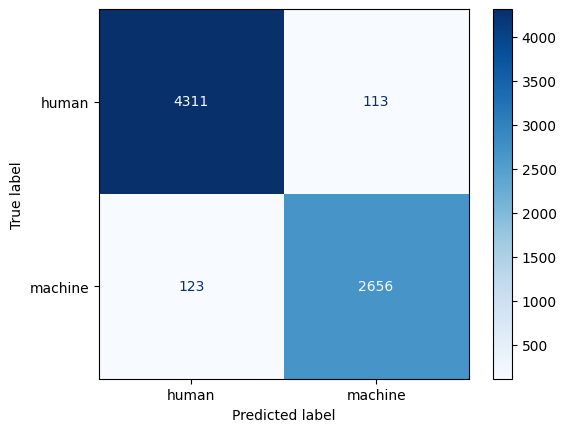

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(tokenized_test_ds['label'], processed_predictions)

labels = ['human', 'machine']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [15]:
file_name = f"{project_name}.ipynb"
html_file_name = f"{file_name.replace('.ipynb', '.html')}"

command = f"jupyter nbconvert '{file_name}' --to html --output-dir './html' --output '{html_file_name}'"
get_ipython().system(command)

[NbConvertApp] Converting notebook praxis-gpt2-xl-small-finetune-v12.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 1297087 bytes to html/praxis-gpt2-xl-small-finetune-v12.html
